### Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.class_weight import compute_sample_weight


import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

### Load Cleaned Data Set

In [7]:
train_data = pd.read_csv("..\\Data\\train_data_EDA_processed.csv", index_col=0)

In [8]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,22073,22074,22075,22076,22077,22078,22079,22080,22081,22082
Patient_Age,2.0,4.0,6.0,12.0,11.0,14.0,3.0,3.0,11.0,4.0,...,13.0,4.0,10.0,0.0,9.0,4.0,8.0,8.0,7.0,11.0
Mother_Gene,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,...,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes
Father_Gene,No,Yes,No,No,No,No,No,No,No,Yes,...,Yes,No,No,No,Yes,Yes,Yes,No,No,No
Maternal_Gene,Yes,No,No,Yes,NaN,Yes,Yes,Yes,Yes,Yes,...,No,NaN,Yes,Yes,Yes,Yes,No,Yes,Yes,No
Paternal_Gene,No,No,No,No,Yes,No,Yes,Yes,No,Yes,...,Yes,No,Yes,No,Yes,No,Yes,No,Yes,No
Blood_Cell,4.760603,4.910669,4.893297,4.70528,4.720703,5.103188,4.90108,4.964816,5.209058,4.752272,...,4.874635,4.789307,4.64386,4.931758,5.012599,5.258298,4.97422,5.18647,4.858543,4.738067
Mother_Age,NaN,NaN,41.0,21.0,32.0,NaN,NaN,40.0,45.0,44.0,...,44.0,35.0,49.0,NaN,47.0,35.0,NaN,35.0,19.0,32.0
Father_Age,NaN,23.0,22.0,NaN,NaN,NaN,63.0,NaN,44.0,42.0,...,62.0,51.0,NaN,50.0,NaN,64.0,56.0,51.0,NaN,62.0
Status,Alive,Deceased,Alive,Deceased,Alive,Deceased,Alive,Alive,Alive,Alive,...,Alive,Alive,Deceased,Alive,Deceased,Deceased,Alive,Deceased,Alive,Deceased
Respiratory_Rate,Normal (30-60),Tachypnea,Normal (30-60),Tachypnea,Tachypnea,NaN,Normal (30-60),Tachypnea,Tachypnea,Tachypnea,...,Tachypnea,Tachypnea,NaN,Normal (30-60),NaN,Normal (30-60),Normal (30-60),Tachypnea,Tachypnea,Normal (30-60)


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19915 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient_Age           18672 non-null  float64
 1   Mother_Gene           19915 non-null  object 
 2   Father_Gene           19652 non-null  object 
 3   Maternal_Gene         17510 non-null  object 
 4   Paternal_Gene         19915 non-null  object 
 5   Blood_Cell            19915 non-null  float64
 6   Mother_Age            14719 non-null  float64
 7   Father_Age            14796 non-null  float64
 8   Status                19915 non-null  object 
 9   Respiratory_Rate      18058 non-null  object 
 10  Heart_Rate            18127 non-null  object 
 11  Follow_Up             18070 non-null  object 
 12  Gender                12008 non-null  object 
 13  Birth_Asphyxia        9060 non-null   object 
 14  Autopsy_Birth_Defect  9013 non-null   object 
 15  Birth_Place        

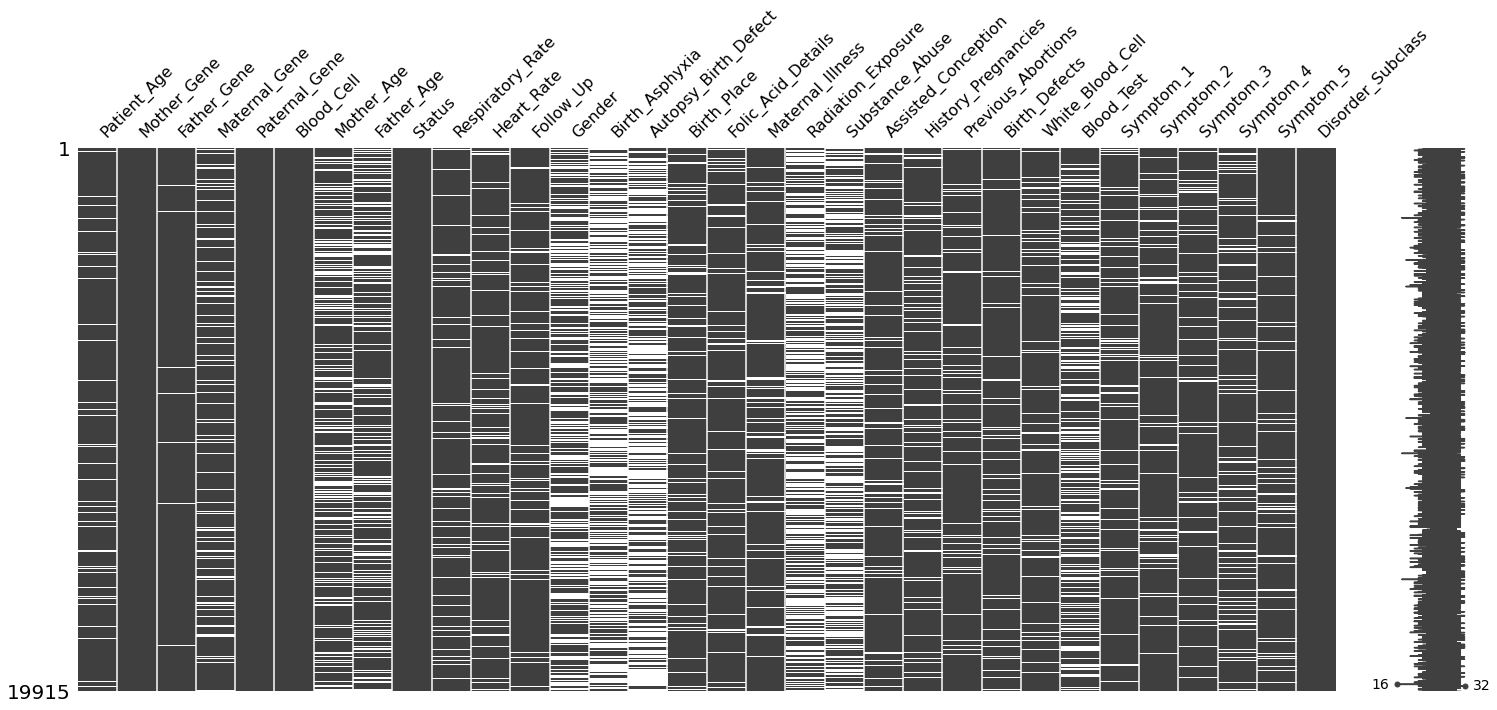

In [10]:
msno.matrix(train_data)
plt.show()

### Road-Map Preprocessing 

Given the large amounts of missing data within certain columns and the misrepresentation effect that a mean or median imputation would have on the data when identifying disorder subclasses, I decided to go with constant imputation. Using constant imputation and creating missing values as its own catagorical group, I will have the model decide what information the missing values will be able to provide when classifying. Thus I will look into RandomForestClassifier, GradientBoostingClassifier and XGBoost, since they all use tree based modeling which are able to split on constant imputed missing values. These model algorithms also do not care and actually performs better without OneHotEncoding. This way, I will be able to keep track of my features.

### Preprocessing Pipeline

In [11]:
# Split the data into feature X and target y
X = train_data.drop(columns="Disorder_Subclass")
y = train_data.Disorder_Subclass

# Label encode target y
le = LabelEncoder()
encoded_y = le.fit_transform(y)

In [12]:
# Train Test Split by 20%
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.2, random_state=123)

In [13]:
# Grouped numerical columns
num_cols = train_data.select_dtypes('float64').columns

# Grouped categorical columns
cat_cols = train_data.select_dtypes('object').drop(columns="Disorder_Subclass").columns

# Preprocessing for numerical data
num_preprocessor = SimpleImputer(strategy='constant', fill_value=-99)

# Preprocessing for categorical data
cat_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="-99")),
                                   ('oe', OrdinalEncoder())])

# Combine num and cat preprocessor for data frame transformation
preprocessor = ColumnTransformer(
    transformers=[('num_transformer', num_preprocessor, num_cols),
                  ('cat_transformer', cat_preprocessor, cat_cols)])

In [14]:
# Preprocessor Test
feature_col_names = train_data.drop(columns="Disorder_Subclass").columns
preprocessed_df = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
preprocessed_df.columns = feature_col_names
preprocessed_df.head()

,Patient_Age,Mother_Gene,Father_Gene,Maternal_Gene,Paternal_Gene,Blood_Cell,Mother_Age,Father_Age,Status,Respiratory_Rate,...,History_Pregnancies,Previous_Abortions,Birth_Defects,White_Blood_Cell,Blood_Test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,6.0,4.816182,23.0,32.0,4.0,5.321413,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,2.0,0.0
1,13.0,5.005324,28.0,44.0,-99.0,4.334729,1.0,1.0,1.0,-99.0,...,1.0,0.0,2.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0
2,10.0,4.712737,26.0,-99.0,-99.0,8.649998,1.0,0.0,0.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,13.0,5.095956,-99.0,36.0,-99.0,7.548971,1.0,1.0,0.0,1.0,...,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0
4,8.0,4.847835,28.0,56.0,4.0,6.962187,1.0,1.0,-99.0,1.0,...,0.0,2.0,1.0,2.0,2.0,0.0,2.0,1.0,2.0,1.0


In [15]:
pd.DataFrame(preprocessor.fit_transform(X_train, y_train)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15932 entries, 0 to 15931
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       15932 non-null  float64
 1   1       15932 non-null  float64
 2   2       15932 non-null  float64
 3   3       15932 non-null  float64
 4   4       15932 non-null  float64
 5   5       15932 non-null  float64
 6   6       15932 non-null  float64
 7   7       15932 non-null  float64
 8   8       15932 non-null  float64
 9   9       15932 non-null  float64
 10  10      15932 non-null  float64
 11  11      15932 non-null  float64
 12  12      15932 non-null  float64
 13  13      15932 non-null  float64
 14  14      15932 non-null  float64
 15  15      15932 non-null  float64
 16  16      15932 non-null  float64
 17  17      15932 non-null  float64
 18  18      15932 non-null  float64
 19  19      15932 non-null  float64
 20  20      15932 non-null  float64
 21  21      15932 non-null  float64
 22

### Baseline Model Comparisons

In [16]:
# RandomForestClassifier
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('randomforest', RandomForestClassifier(random_state=123))])

pipe_rf.fit(X_train, y_train)

pred_tr = pipe_rf.predict(X_train)
pred_te = pipe_rf.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

100.0
37.98644238011549
Scores: [37.05679322 37.02541575 38.07281858 36.47206529 38.63779033]
Mean: 37.45297663471601
Standard Deviation: 0.007861226644058908


In [17]:
# GradientBoostingClassifier
pipe_gb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('gradientboosting', GradientBoostingClassifier(random_state=123))])

pipe_gb.fit(X_train, y_train)

pred_tr = pipe_gb.predict(X_train)
pred_te = pipe_gb.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_gb, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

48.70700477027366
40.321365804669846
Scores: [41.5123941  40.25729526 41.9648462  39.04582549 40.20715631]
Mean: 40.597503472105274
Standard Deviation: 0.01037542106070992


In [18]:
# XGBClassifier
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgboost', xgb.XGBClassifier(random_state=123))])

pipe_xgb.fit(X_train, y_train)

pred_tr = pipe_xgb.predict(X_train)
pred_te = pipe_xgb.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

[22:10:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
95.93899071051972
36.75621390911373
[22:10:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in X

Evaluating on the cross validated mean scores for each model, the GradientBoostingClassifier had the highest score with 40.6, but looking at its training score, it performed poorly at 48.7. For both the RandomForestClassifier and XGBClassifier, both have really high train score, showing that there is overfitting that can be regularized. But the XGBoost performed slightly better than the RandomForest.
I will be following through with XGBoost since it can deal well with imbalanced classes in my data set, as well being robust in modeling large amounts of missing data.

### Defining Baseline Model

In [76]:
# Adding Class Weight due to heavy imbalance of dataset seen in the EDA
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [77]:
# Default parameters set to multi-classification
params = {
    'objective':'multi:softmax',
    'eval_metric':'mlogloss',
    'seed':123
}

In [87]:
pipe_initial = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgboost', xgb.XGBClassifier(**params))])

pipe_initial.fit(X_train, y_train, xgboost__sample_weight=sample_weights)

pred_tr = pipe_initial.predict(X_train)
pred_te = pipe_initial.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

92.58096911875471
35.32513181019332


In [98]:
# Cross Validation Score
scores = cross_val_score(pipe_initial, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [37.15092564 37.6215877  39.98744507 37.22536095 36.34651601]
Mean: 37.66636707386469
Standard Deviation: 0.012321997709810498


In [99]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.24      0.14      0.17        29
           1       0.18      0.09      0.12        23
           2       0.39      0.48      0.43       647
           3       0.30      0.30      0.30       346
           4       0.29      0.36      0.32       266
           5       0.23      0.19      0.21       126
           6       0.42      0.34      0.38      1072
           7       0.36      0.33      0.34       901
           8       0.30      0.35      0.32       573

    accuracy                           0.35      3983
   macro avg       0.30      0.29      0.29      3983
weighted avg       0.36      0.35      0.35      3983



In [41]:
for i, val in enumerate(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])):
    print(i, val)

0 Alzheimer's
1 Cancer
2 Cystic fibrosis
3 Diabetes
4 Hemochromatosis
5 Leber's hereditary optic neuropathy
6 Leigh syndrome
7 Mitochondrial myopathy
8 Tay-Sachs


The default parameters for XGBoost looks to be overfitting given that the score for the train split has a score around 96, while the test split has a score around 37. This is supported by the cross validation with a mean score of 37. Hyperparameter tuning will hopefully reduce the overfitting and increase the accuracy on the test split.

In [ ]:
### TO BE DELETED, PLACE HOLDER

In [ ]:
hype_params = {
    'xgb_model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'xgb_model__n_estimators': range(50, 500),
    'xgb_model__max_depth': range(2, 16, 2),
    'xgb_model__min_child_weight': range(1,6,2),
    'xgb_model__gamma':[i/10.0 for i in range(0,5)],
    'xgb_model__subsample':[i/10.0 for i in range(6,10)],
    'xgb_model__colsample_bytree':[i/10.0 for i in range(6,10)],
    lambda':[i/10.0 for i in range(7,16)]
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

### Random Search and Grid Search with CV Functions

In [122]:
def rand_search_eval(hype_params):
    
    """
    Function performs RandomizedSearchCV on inputted hyper parameters.
    After models are created, the mean score and standard deviation of each iteration is stored.
    The model is graphed against F1_Macro score.
    The top 5 models are listed with their scores and iteration number for identification
    Best parameters and best score are printed too.
    """
    
    # Random Search with CV of the hyper parameters
    rand_search = RandomizedSearchCV(
        estimator=pipe_tuning,
        param_distributions=hype_params,
        scoring = 'f1_macro',
        n_iter = 20,
        cv = 5,
        verbose=True,
        random_state=123
    )
    
    # Fit and CV models with hyper parameters
    rand_search.fit(X_train, y_train, xgb_model__sample_weight=sample_weights)
    
    # Mean and Standard Deviation from iteration
    mean_score = list(rand_search.cv_results_['mean_test_score'])
    stds_score = list(rand_search.cv_results_['std_test_score'])
    
    # Graphs each iteration and its F1_Macro score
    plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
    plt.title("Rand_Search Iteration vs F1_Macro Score")
    plt.xlabel("Iteration")
    plt.ylabel("f1_score")
    plt.show()
    
    # Prints the top 5 scores with iteration number
    print(sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5])
    
    print("Best Parameters: ", rand_search.best_params_)
    print("Best Score: ", rand_search.best_score_)
    
    return(rand_search)

In [123]:
def grid_search_eval(hype_params):
    
    """
    Function performs GridSearchCV on inputted hyper parameters.
    After models are created, the mean score and standard deviation of each iteration is stored.
    The model is graphed against F1_Macro score.
    The top 5 models are listed with their scores and iteration number for identification
    Best parameters and best score are printed too.
    """
    
    # Grid Search with CV of the hyper parameters
    grid_search = GridSearchCV(
        estimator=pipe_tuning,
        param_grid=hype_params,
        scoring = 'f1_macro',
        cv = 5,
        verbose=True
    )
    
    # Fit and CV models with hyper parameters
    grid_search.fit(X_train, y_train, xgb_model__sample_weight=sample_weights)
    
    # Mean and Standard Deviation from iteration
    mean_score = list(grid_search.cv_results_['mean_test_score'])
    stds_score = list(grid_search.cv_results_['std_test_score'])
    
    # Graphs each iteration and its F1_Macro score
    plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
    plt.title("Grid_Search Iteration vs F1_Macro Score")
    plt.xlabel("Iteration")
    plt.ylabel("f1_score")
    plt.show()
    
    # Prints the top 5 scores with iteration number
    print(sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5])
    
    print("Best Parameters: ", rand_search.best_params_)
    print("Best Score: ", rand_search.best_score_)
    
    return(grid_search)

### Hyperparameter Tuning

In [124]:
# Base model with weighted class for the imbalance data set to tune
pipe_tuning = Pipeline(steps=[('preprocessor', preprocessor),
                              ('xgb_model', xgb.XGBClassifier(**params))])

Initial parameter ranges were chosen based on articles about tuning parameters as a starting point.

#### learning_rate and n_estimators

In [125]:
# Finding initial learning_rate and n_estimators.
hype_params = {
    'xgb_model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
    'xgb_model__n_estimators': range(50, 1000, 50),
}

In [126]:
rand_search = rand_search_eval(hype_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [121]:
rand_search.cv_results_['params'][0]

{'xgb_model__n_estimators': 500, 'xgb_model__learning_rate': 0.4}

In [288]:
# Tuning the parameters based on the rand_search results
hype_params = {
    'xgb_model__learning_rate': [0.1],
    'xgb_model__n_estimators': range(80, 130, 10),
}

In [290]:
grid_search_eval(hype_params)

In [308]:
hype_params['xgb_model__learning_rate'] = [0.1]
hype_params['xgb_model__n_estimators'] = [100]

Set the initial tuned parameters for learning_rate and n_estimators, and then continue with tuning the tree parameters. I will come back to the learning_rate and n_estimator one more time at the end of the optimization.

#### Tree Parameters: max_depth, min_child_weight, gamma

In [309]:
hype_params['xgb_model__max_depth'] = range(2, 16, 2)
hype_params['xgb_model__min_child_weight'] = range(1,6,2)
hype_params['xgb_model__gamma'] = [i/10.0 for i in range(0,5)]

In [310]:
rand_search = RandomizedSearchCV(
    estimator=pipe_2,
    param_distributions=hype_params,
    scoring = 'f1_macro',
    n_iter = 10,
    cv = 5,
    verbose=True,
    random_state=123
)

In [311]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_transformer',
                                                                               SimpleImputer(fill_value=-99,
                                                                                             strategy='constant'),
                                                                               Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                              ('cat...
                                                            scale_pos_weight=None,
                                                            seed=123,
                                                            su

In [312]:
rand_search.best_params_

{'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 5,
 'xgb_model__max_depth': 8,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2}

In [315]:
rand_search.best_score_

0.2953408328269985

In [327]:
mean_score = list(rand_search.cv_results_['mean_test_score'])
stds_score = list(rand_search.cv_results_['std_test_score'])

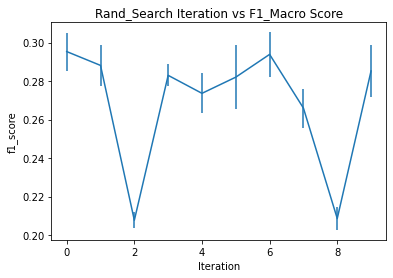

In [330]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Rand_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

Iteration 0 and 6 looks to have the highest scores with their randomized parameters.

In [337]:
rand_search.cv_results_['params'][0]

{'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 5,
 'xgb_model__max_depth': 8,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2}

In [338]:
rand_search.cv_results_['params'][6]

{'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 5,
 'xgb_model__max_depth': 6,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.0}

My new grid_search parameters will include both rand_search parameters that had the best scores.

In [358]:
hype_params['xgb_model__max_depth'] = range(5, 10)
hype_params['xgb_model__min_child_weight'] = range(4,7)
hype_params['xgb_model__gamma'] = np.arange(0, 0.4, 0.1)

In [359]:
grid_search = GridSearchCV(
    estimator=pipe_2,
    param_grid=hype_params,
    scoring = 'f1_macro',
    cv = 5,
    verbose=True,
)

In [360]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         SimpleImputer(fill_value=-99,
                                                                                       strategy='constant'),
                                                                         Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                        ('cat_trans...
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                 

In [364]:
mean_score = list(grid_search.cv_results_['mean_test_score'])
stds_score = list(grid_search.cv_results_['std_test_score'])

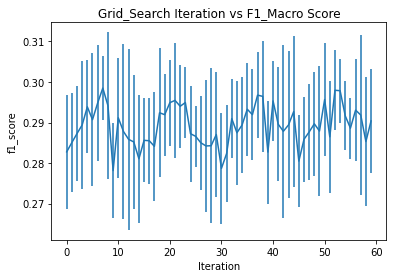

In [365]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Grid_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

In [377]:
sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5]

[(7, 0.29850871072905855),
 (52, 0.2979692659309125),
 (53, 0.2978607889157467),
 (37, 0.2967703665223703),
 (38, 0.29646386364126975)]

In [378]:
grid_search.cv_results_['params'][7]

{'xgb_model__gamma': 0.0,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 5,
 'xgb_model__n_estimators': 100}

In [379]:
grid_search.cv_results_['params'][52]

{'xgb_model__gamma': 0.30000000000000004,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 5,
 'xgb_model__n_estimators': 100}

In [380]:
grid_search.cv_results_['params'][53]

{'xgb_model__gamma': 0.30000000000000004,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 6,
 'xgb_model__n_estimators': 100}

In [381]:
grid_search.cv_results_['params'][37]

{'xgb_model__gamma': 0.2,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 5,
 'xgb_model__n_estimators': 100}

In [382]:
grid_search.cv_results_['params'][38]

{'xgb_model__gamma': 0.2,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 6,
 'xgb_model__n_estimators': 100}

In [361]:
grid_search.best_params_

{'xgb_model__gamma': 0.0,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 5,
 'xgb_model__n_estimators': 100}

In [363]:
grid_search.best_score_

0.29850871072905855

The best model generated is only slightly better compared to the 2nd rate model, but is technicially better relativity when 2nd and 3rd rate models are compared.

In [385]:
hype_params['xgb_model__learning_rate'] = [0.1]
hype_params['xgb_model__n_estimators'] = [100]
hype_params['xgb_model__gamma'] = [0.2]
hype_params['xgb_model__max_depth'] = [7]
hype_params['xgb_model__min_child_weight'] = [6]

The optimal parameters for gamma, max_depth, and min_child_weight are set for the hyperparameters. The next set of parameters to tune will be subsample and colsample_bytree.

#### subsample and colsample_bytree

In [386]:
hype_params['xgb_model__subsample'] = [i/10.0 for i in range(6,10)]
hype_params['xgb_model__colsample_bytree'] = [i/10.0 for i in range(6,10)]

In [387]:
rand_search = RandomizedSearchCV(
    estimator=pipe_2,
    param_distributions=hype_params,
    scoring = 'f1_macro',
    n_iter = 10,
    cv = 5,
    verbose=True,
    random_state=123
)

In [388]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_transformer',
                                                                               SimpleImputer(fill_value=-99,
                                                                                             strategy='constant'),
                                                                               Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                              ('cat...
                                                            tree_method=None,
                                                            use_label_encoder=False, ...))]),
                   param_distributions={'xg

In [389]:
rand_search.best_params_

{'xgb_model__subsample': 0.6,
 'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 6,
 'xgb_model__max_depth': 7,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2,
 'xgb_model__colsample_bytree': 0.8}

In [390]:
rand_search.best_score_

0.2921600581675424

In [391]:
mean_score = list(rand_search.cv_results_['mean_test_score'])
stds_score = list(rand_search.cv_results_['std_test_score'])

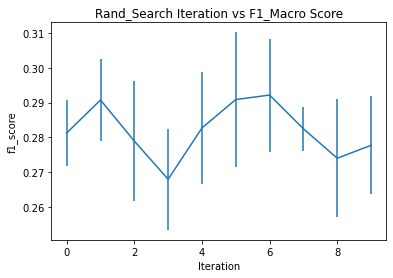

In [392]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Rand_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

In [393]:
rand_search.cv_results_['params'][1]

{'xgb_model__subsample': 0.8,
 'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 6,
 'xgb_model__max_depth': 7,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2,
 'xgb_model__colsample_bytree': 0.8}

In [394]:
rand_search.cv_results_['params'][5]

{'xgb_model__subsample': 0.7,
 'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 6,
 'xgb_model__max_depth': 7,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2,
 'xgb_model__colsample_bytree': 0.8}

In [395]:
rand_search.cv_results_['params'][6]

{'xgb_model__subsample': 0.6,
 'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 6,
 'xgb_model__max_depth': 7,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2,
 'xgb_model__colsample_bytree': 0.8}

My new grid_search parameters will cover the top 3 model parameters and a bit on either ends.

In [415]:
hype_params['xgb_model__subsample'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
hype_params['xgb_model__colsample_bytree'] = [0.6, 0.7, 0.8, 0.9, 1]

In [416]:
grid_search = GridSearchCV(
    estimator=pipe_2,
    param_grid=hype_params,
    scoring = 'f1_macro',
    cv = 5,
    verbose=True,
)

In [417]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         SimpleImputer(fill_value=-99,
                                                                                       strategy='constant'),
                                                                         Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                        ('cat_trans...
                                                      seed=123, subsample=None,
                                                      tree_method=None,
                                                      use_label_encoder=False, ...))]),
           

In [418]:

mean_score = list(grid_search.cv_results_['mean_test_score'])
stds_score = list(grid_search.cv_results_['std_test_score'])

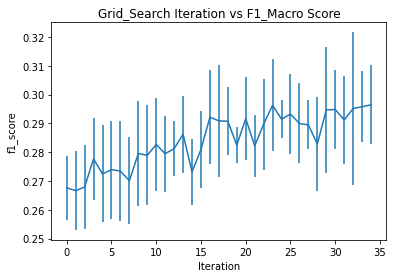

In [419]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Grid_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

In [420]:
sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5]

[(34, 0.29646386364126975),
 (23, 0.29629694030904036),
 (33, 0.2957800749686245),
 (32, 0.2951665080024468),
 (30, 0.2948239103298115)]

In [421]:
grid_search.best_params_

{'xgb_model__colsample_bytree': 1,
 'xgb_model__gamma': 0.2,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 6,
 'xgb_model__n_estimators': 100,
 'xgb_model__subsample': 1}

In [426]:
grid_search.best_score_

0.29646386364126975

Although there is a positive trend in the metric graph for increased colsample_bytree and subsample, both parameters are maximized at 1. So these will be my values for these parameters. This could be something to revisit if other parameters are adjusted.

In [451]:
hype_params['xgb_model__subsample'] = [1]
hype_params['xgb_model__colsample_bytree'] = [1]

#### Tuning Regularization: reg_lambda

I will be tuning lambda rather then alpha since the amount of features I have for my data is relatively small and does not need dimensional reduction.

In [463]:
hype_params['xgb_model__reg_lambda'] = [i/10.0 for i in range(7,16)]

In [464]:
rand_search = RandomizedSearchCV(
    estimator=pipe_2,
    param_distributions=hype_params,
    scoring = 'f1_macro',
    n_iter = 10,
    cv = 5,
    verbose=True,
    random_state=123
)

In [465]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_transformer',
                                                                               SimpleImputer(fill_value=-99,
                                                                                             strategy='constant'),
                                                                               Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                              ('cat...
                                                            use_label_encoder=False, ...))]),
                   param_distributions={'xgb_model__colsample_bytree': [1],
                                        'xgb_

In [466]:
rand_search.best_params_

{'xgb_model__subsample': 1,
 'xgb_model__reg_lambda': 1.2,
 'xgb_model__n_estimators': 100,
 'xgb_model__min_child_weight': 6,
 'xgb_model__max_depth': 7,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 0.2,
 'xgb_model__colsample_bytree': 1}

In [467]:
rand_search.best_score_

0.2993398217140989

In [468]:
mean_score = list(rand_search.cv_results_['mean_test_score'])
stds_score = list(rand_search.cv_results_['std_test_score'])

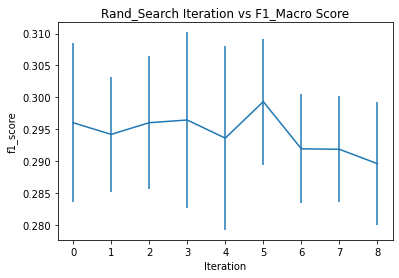

In [469]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Rand_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

In [470]:
hype_params['xgb_model__reg_lambda'] = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]

In [471]:
grid_search = GridSearchCV(
    estimator=pipe_2,
    param_grid=hype_params,
    scoring = 'f1_macro',
    cv = 5,
    verbose=True,
)

In [472]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         SimpleImputer(fill_value=-99,
                                                                                       strategy='constant'),
                                                                         Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                        ('cat_trans...
                                                      tree_method=None,
                                                      use_label_encoder=False, ...))]),
             param_grid={'xgb_model__colsample_bytree': [1],
                         'xgb_

In [473]:
mean_score = list(grid_search.cv_results_['mean_test_score'])
stds_score = list(grid_search.cv_results_['std_test_score'])

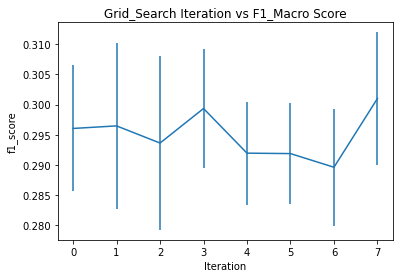

In [474]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Grid_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

Performing Gridsearch again, but with an increased upper limit.

In [478]:
hype_params['xgb_model__reg_lambda'] = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

In [479]:
grid_search = GridSearchCV(
    estimator=pipe_2,
    param_grid=hype_params,
    scoring = 'f1_macro',
    cv = 5,
    verbose=True,
)

In [480]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         SimpleImputer(fill_value=-99,
                                                                                       strategy='constant'),
                                                                         Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                        ('cat_trans...
                                                      use_label_encoder=False, ...))]),
             param_grid={'xgb_model__colsample_bytree': [1],
                         'xgb_model__gamma': [0.2],
                         'xgb_model__learning_rate

In [481]:
mean_score = list(grid_search.cv_results_['mean_test_score'])
stds_score = list(grid_search.cv_results_['std_test_score'])

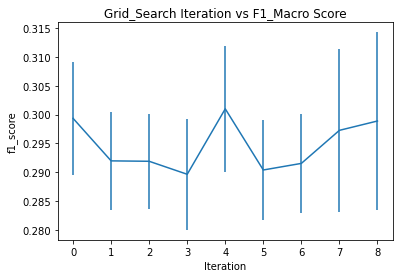

In [482]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Grid_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

In [483]:
list(enumerate(mean_score))

[(0, 0.2993398217140989),
 (1, 0.2919537690629776),
 (2, 0.29188154860908266),
 (3, 0.2896231864394682),
 (4, 0.30099208953950723),
 (5, 0.290369422919334),
 (6, 0.2915137776739861),
 (7, 0.297255037997548),
 (8, 0.2988785625319179)]

In [484]:
grid_search.best_score_

0.30099208953950723

In [485]:
grid_search.best_params_

{'xgb_model__colsample_bytree': 1,
 'xgb_model__gamma': 0.2,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 6,
 'xgb_model__n_estimators': 100,
 'xgb_model__reg_lambda': 1.6,
 'xgb_model__subsample': 1}

In [486]:
hype_params['xgb_model__reg_lambda'] = [1.6]

#### Checking back on learning_rate and n_estimator

After all other parameters have been set to optimal values, I am going to re-evaluate the learning_rate and n_estimator to see if there are impovements with deeper learning parameters. Lower value for learning_rate and higher value for n_estimator. I will be going straight to GridSearch given I have initial parameters and range to work with.

In [490]:
hype_params['xgb_model__learning_rate'] = [0.001, 0.01, 0.05, 0.1, 1.5, 0.2, 0.3]
hype_params['xgb_model__n_estimators'] = [70, 80, 90, 100, 110, 120, 130]

In [491]:
grid_search = GridSearchCV(
    estimator=pipe_2,
    param_grid=hype_params,
    scoring = 'f1_macro',
    cv = 5,
    verbose=True,
)

In [492]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         SimpleImputer(fill_value=-99,
                                                                                       strategy='constant'),
                                                                         Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                                        ('cat_trans...
                                                      use_label_encoder=False, ...))]),
             param_grid={'xgb_model__colsample_bytree': [1],
                         'xgb_model__gamma': [0.2],
                         'xgb_model__learning_rate

In [493]:
mean_score = list(grid_search.cv_results_['mean_test_score'])
stds_score = list(grid_search.cv_results_['std_test_score'])

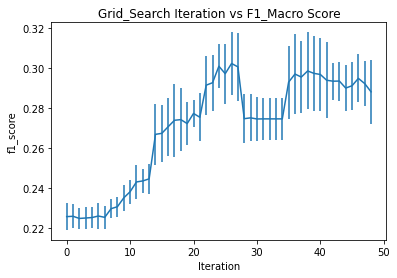

In [494]:
plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
plt.title("Grid_Search Iteration vs F1_Macro Score")
plt.xlabel("Iteration")
plt.ylabel("f1_score")
plt.show()

In [495]:
grid_search.best_params_

{'xgb_model__colsample_bytree': 1,
 'xgb_model__gamma': 0.2,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 7,
 'xgb_model__min_child_weight': 6,
 'xgb_model__n_estimators': 120,
 'xgb_model__reg_lambda': 1.6,
 'xgb_model__subsample': 1}

In [496]:
grid_search.best_score_

0.30235761740568246

## Feature Importance Code

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

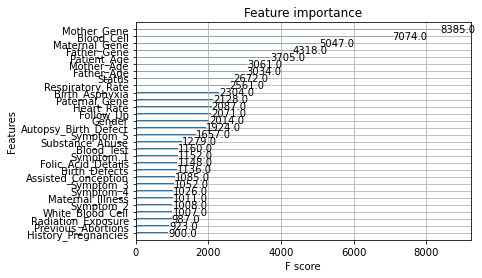

In [112]:
final_model.get_booster().feature_names = list(feature_col_names)
xgb.plot_importance(final_model.get_booster(), max_num_features=30)

<Figure size 2160x2160 with 0 Axes>

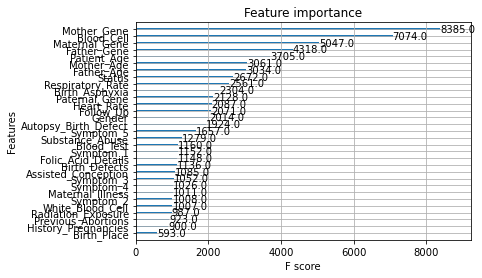

In [108]:
plt.figure(figsize=(30,30))
xgb.plot_importance(final_model, show_values=True)
plt.show()

In [95]:
print(final_model.get_booster().feature_names)

['Patient_Age', 'Mother_Gene', 'Father_Gene', 'Maternal_Gene', 'Paternal_Gene', 'Blood_Cell', 'Mother_Age', 'Father_Age', 'Status', 'Respiratory_Rate', 'Heart_Rate', 'Follow_Up', 'Gender', 'Birth_Asphyxia', 'Autopsy_Birth_Defect', 'Birth_Place', 'Folic_Acid_Details', 'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse', 'Assisted_Conception', 'History_Pregnancies', 'Previous_Abortions', 'Birth_Defects', 'White_Blood_Cell', 'Blood_Test', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5']


In [100]:
final_model.get_booster().feature_names

In [570]:
hype_params

{'xgb_model__learning_rate': [0.001, 0.01, 0.05, 0.1, 1.5, 0.2, 0.3],
 'xgb_model__n_estimators': [70, 80, 90, 100, 110, 120, 130],
 'xgb_model__max_depth': [7],
 'xgb_model__min_child_weight': [6],
 'xgb_model__gamma': [0.2],
 'xgb_model__subsample': [1],
 'xgb_model__colsample_bytree': [1],
 'xgb_model__reg_lambda': [1.6]}

In [590]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe_3, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

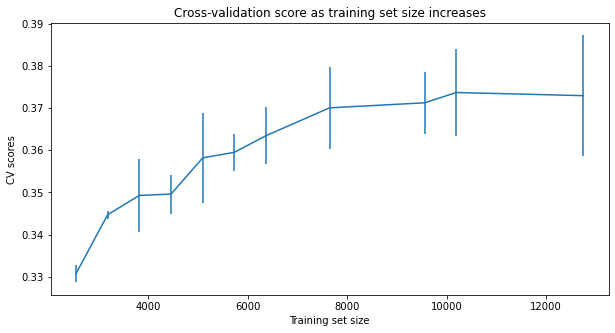

In [591]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');
plt.show()

In [592]:
train_data

,Patient_Age,Mother_Gene,Father_Gene,Maternal_Gene,Paternal_Gene,Blood_Cell,Mother_Age,Father_Age,Status,Respiratory_Rate,...,Previous_Abortions,Birth_Defects,White_Blood_Cell,Blood_Test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Disorder_Subclass
0,2.0,Yes,No,Yes,No,4.760603,NaN,NaN,Alive,Normal (30-60),...,NaN,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,NaN,23.0,Deceased,Tachypnea,...,NaN,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,Cystic fibrosis
2,6.0,Yes,No,No,No,4.893297,41.0,22.0,Alive,Normal (30-60),...,4.0,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Diabetes
3,12.0,Yes,No,Yes,No,4.705280,21.0,NaN,Deceased,Tachypnea,...,1.0,Singular,7.919321,NaN,0.0,0.0,1.0,0.0,0.0,Leigh syndrome
4,11.0,Yes,No,NaN,Yes,4.720703,32.0,NaN,Alive,Tachypnea,...,4.0,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,4.0,Yes,Yes,Yes,No,5.258298,35.0,64.0,Deceased,Normal (30-60),...,3.0,Multiple,6.584811,NaN,0.0,0.0,1.0,0.0,0.0,Leigh syndrome
22079,8.0,No,Yes,No,Yes,4.974220,NaN,56.0,Alive,Normal (30-60),...,2.0,Multiple,7.041556,NaN,1.0,1.0,1.0,1.0,0.0,Diabetes
22080,8.0,Yes,No,Yes,No,5.186470,35.0,51.0,Deceased,Tachypnea,...,2.0,Singular,7.715464,normal,0.0,0.0,0.0,1.0,NaN,Mitochondrial myopathy
22081,7.0,Yes,No,Yes,Yes,4.858543,19.0,NaN,Alive,Tachypnea,...,1.0,Multiple,8.437670,abnormal,1.0,1.0,1.0,0.0,0.0,Leigh syndrome


In [98]:
final_model = xgb.XGBClassifier(objective='Multi:softmax', eval_metric="mlogloss", use_label_encoder=False, seed=123,
                            colsample_bytree=1,
                            gamma=0.2,
                            learning_rate=0.1,
                            max_depth=7,
                            min_child_weight=6,
                            n_estimators=120,
                            reg_lambda=1.6,
                            subsample=1
)

pipe_3 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('xgb_model', final_model)])

pipe_3.fit(X_train, y_train)

predTrain_3 = pipe_3.predict(X_train)
predTest_3 = pipe_3.predict(X_test)

print(accuracy_score(y_train, predTrain_3) * 100)
print(accuracy_score(y_test, predTest_3) * 100)

88.22495606326889
37.00728094401205


In [595]:
# Cross Validation Score
scores = cross_val_score(pipe_3, X_train, y_train, cv=5, scoring="f1_macro")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [30.23203331 31.8954115  31.68237625 27.55833453 29.81065312]
Mean: 30.235761740568247
Standard Deviation: 0.015618244822954147


In [211]:
print(classification_report(y_test, predTest_1))

              precision    recall  f1-score   support

           0       0.20      0.03      0.06        29
           1       0.75      0.13      0.22        23
           2       0.42      0.56      0.48       647
           3       0.33      0.23      0.27       346
           4       0.37      0.26      0.30       266
           5       0.35      0.20      0.25       126
           6       0.43      0.45      0.44      1072
           7       0.36      0.39      0.37       901
           8       0.33      0.30      0.32       573

    accuracy                           0.39      3983
   macro avg       0.39      0.28      0.30      3983
weighted avg       0.38      0.39      0.38      3983



In [45]:
pipe_gb.fit(X, encoded_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  SimpleImputer(fill_value=-999,
                                                                strategy='constant'),
                                                  Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('i...
       'Status', 'Respiratory_Rate', 'Heart_Rate', 'Follow_Up', 'Gender',
       'Birth_Asphyxia', 'Autopsy_Birth_Defect', 'Birth_Place',
       'Folic_Acid_Details', 'Maternal_Illness', 'Radiation_Exposure',
       'Substance_Abuse', 'Assisted_Conception', 'History_Pregnancies',
       'Birth_Defects', 'Blood_Test'],
      dty

In [46]:
test_data = pd.read_csv("..\\Data\\test_data_cleaned.csv", index_col=0)

In [47]:
test_data

,Patient_Age,Mother_Gene,Father_Gene,Maternal_Gene,Paternal_Gene,Blood_Cell,Mother_Age,Father_Age,Status,Respiratory_Rate,...,History_Pregnancies,Previous_Abortions,Birth_Defects,White_Blood_Cell,Blood_Test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,6,No,Yes,No,No,4.981655,38,61,Alive,Tachypnea,...,NaN,2.0,Multiple,NaN,slightly abnormal,True,True,True,True,True
1,10,Yes,No,NaN,Yes,5.118890,33,53,Alive,NaN,...,Yes,NaN,Multiple,8.179584,normal,False,False,False,True,False
2,5,No,NaN,No,No,4.876204,48,60,Deceased,NaN,...,No,0.0,Singular,NaN,slightly abnormal,False,False,True,True,False
3,13,No,Yes,Yes,No,4.687767,25,55,Alive,NaN,...,Yes,NaN,Singular,6.884071,normal,True,False,True,False,True
4,5,No,NaN,NaN,Yes,5.152362,41,38,Deceased,Tachypnea,...,No,NaN,Multiple,6.195178,normal,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,9,Yes,Yes,NaN,No,4.878335,28,63,Alive,NaN,...,Yes,2.0,Multiple,7.234960,abnormal,False,True,True,True,False
9461,1,Yes,No,NaN,Yes,4.927151,37,62,Deceased,NaN,...,No,NaN,Singular,4.859536,abnormal,False,True,False,True,True
9462,2,No,Yes,No,No,4.898352,24,32,Deceased,Tachypnea,...,No,3.0,NaN,5.696062,normal,False,True,False,False,True
9463,13,No,Yes,No,No,4.804840,36,56,Alive,NaN,...,NaN,1.0,Singular,3.000000,NaN,True,True,True,True,True


In [48]:
outputData = pipe_gb.predict(test_data)

In [49]:
output_df = pd.DataFrame(le.inverse_transform(outputData))

In [50]:
Disorder_Subclass = []

for val in output_df[0]:
    if val == "Cystic fibrosis":
        Disorder_Subclass.append("Single-gene inheritance diseases")
    elif val == "Hemochromatosis":
        Disorder_Subclass.append("Single-gene inheritance diseases")
    elif val == "Tay-Sachs":
        Disorder_Subclass.append("Single-gene inheritance diseases")
    elif val == "Diabetes":
        Disorder_Subclass.append("Multifactorial genetic inheritance disorders")
    elif val == "Cancer":
        Disorder_Subclass.append("Multifactorial genetic inheritance disorders")
    elif val == "Alzheimer's":
        Disorder_Subclass.append("Multifactorial genetic inheritance disorders")
    else: Disorder_Subclass.append("Mitochondrial genetic inheritance disorders")
        

In [51]:
output_df[1] = Disorder_Subclass
output_df

,0,1
0,Diabetes,Multifactorial genetic inheritance disorders
1,Mitochondrial myopathy,Mitochondrial genetic inheritance disorders
2,Mitochondrial myopathy,Mitochondrial genetic inheritance disorders
3,Leigh syndrome,Mitochondrial genetic inheritance disorders
4,Cystic fibrosis,Single-gene inheritance diseases
...,...,...
9460,Cystic fibrosis,Single-gene inheritance diseases
9461,Cystic fibrosis,Single-gene inheritance diseases
9462,Mitochondrial myopathy,Mitochondrial genetic inheritance disorders
9463,Diabetes,Multifactorial genetic inheritance disorders


In [52]:
output_df.to_csv('../Data/outputPredicted.csv')

In [12]:
D_train = xgb.DMatrix(preprocessor.fit_transform(X_train), label=y_train)
D_test = xgb.DMatrix(preprocessor.fit_transform(X_test), label=y_test)

#### max_depth and min_child_weight

In [ ]:
gs_params={}}

#### Learning_Rate

In [17]:
# Create list of eta values and empty list to store final round mlogloss per xgboost model
eta_vals = [0.001, 0.01, 0.1, 10, 100]
best_mlogloss = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=50, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_mlogloss)), columns=["eta","mlogloss"]))

       eta   mlogloss
0    0.001   2.175206
1    0.010   2.012427
2    0.100   1.505617
3   10.000   5.070488
4  100.000  20.860645


In [20]:
params["eta"] = 0.1

#### Max_Depth

In [22]:
max_depths = [2, 4, 6, 8, 10, 15, 20]
best_mlogloss = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=30, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
max_depth_df = pd.DataFrame(list(zip(max_depths, best_mlogloss)),columns=["max_depth","best_mlogloss"])
print(max_depth_df)

   max_depth  best_mlogloss
0          2       1.649320
1          4       1.547621
2          6       1.505617
3          8       1.524360
4         10       1.568893
5         15       1.625428
6         20       1.640452


Text(0, 0.5, 'mlogloss')

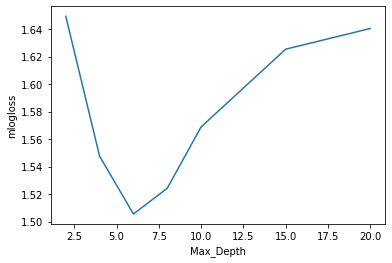

In [27]:
plt.plot(max_depth_df["max_depth"], max_depth_df["best_mlogloss"])
plt.xlabel("Max_Depth")
plt.ylabel("mlogloss")

In [28]:
# Second round max_depth optimization
max_depths = [4, 5, 6, 7, 8]
best_mlogloss = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=30, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
max_depth_df = pd.DataFrame(list(zip(max_depths, best_mlogloss)),columns=["max_depth","best_mlogloss"])
print(max_depth_df)

   max_depth  best_mlogloss
0          4       1.547621
1          5       1.517368
2          6       1.505617
3          7       1.509131
4          8       1.524360


Text(0, 0.5, 'mlogloss')

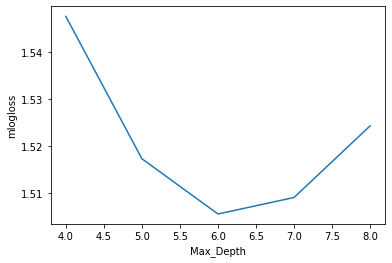

In [29]:
plt.plot(max_depth_df["max_depth"], max_depth_df["best_mlogloss"])
plt.xlabel("Max_Depth")
plt.ylabel("mlogloss")

In [30]:
params["max_depth"] = 6

#### colsample_bytree

In [32]:
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_mlogloss = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=30, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_mlogloss)), columns=["colsample_bytree","best_mlogloss"]))

   colsample_bytree  best_mlogloss
0               0.1       1.762221
1               0.5       1.565242
2               0.8       1.513763
3               1.0       1.505617


In [33]:
params["colsample_bytree"] = 1

In [35]:
params

{'objective': 'multi:softmax',
 'num_class': 9,
 'eta': 0.1,
 'max_depth': 6,
 'colsample_bytree': 1}

In [36]:
xgb_model2 = xgb.XGBClassifier(objective='Multi:softmax', eval_metric="mlogloss", use_label_encoder=False, 
                               num_class=9, eta=0.1, max_depth=6,colsample_bytree=1)

xgb_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                                ('xgb_model', xgb_model2)])

xgb_pipeline2.fit(X_train, y_train)

pred2_train = xgb_pipeline2.predict(X_train)
pred2_test = xgb_pipeline2.predict(X_test)

print(accuracy_score(y_train, pred2_train) * 100)
print(accuracy_score(y_test, pred2_test) * 100)

76.25533517449159
37.911122269646


In [214]:
print(confusion_matrix(y_test, pred1))

[[  2   0   3  16   0   7   1   0   0]
 [  0   3   0   0  13   0   0   0   7]
 [  1   0 336  90   0  19 162  37   2]
 [  2   0 183  84   0  24  45   6   2]
 [  0   1   0   0  65   0  21  62 117]
 [  3   0  60  40   0  18   4   1   0]
 [  0   0 222  20  13   2 442 299  74]
 [  0   0  44   5  41   0 307 343 161]
 [  0   0   2   0  64   0 125 221 161]]


In [215]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.25      0.07      0.11        29
           1       0.75      0.13      0.22        23
           2       0.40      0.52      0.45       647
           3       0.33      0.24      0.28       346
           4       0.33      0.24      0.28       266
           5       0.26      0.14      0.18       126
           6       0.40      0.41      0.41      1072
           7       0.35      0.38      0.37       901
           8       0.31      0.28      0.29       573

    accuracy                           0.37      3983
   macro avg       0.37      0.27      0.29      3983
weighted avg       0.36      0.37      0.36      3983



The cross validation score shows that the initial out of the box model performs poorly with a mean of 0.37 accuracy.

In [209]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])

array(["Alzheimer's", 'Cancer', 'Cystic fibrosis', 'Diabetes',
       'Hemochromatosis', "Leber's hereditary optic neuropathy",
       'Leigh syndrome', 'Mitochondrial myopathy', 'Tay-Sachs'],
      dtype=object)

<Figure size 1080x1080 with 0 Axes>

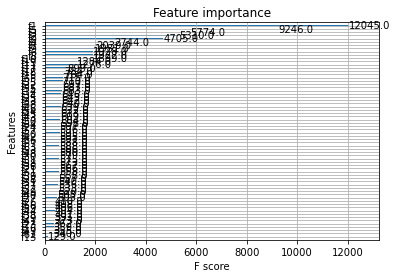

In [165]:
plt.figure(figsize=(15,15))
xgb.plot_importance(xgb_model1)
plt.show()


In [177]:
pd.DataFrame(xgb_model1.feature_importances_).sort_values(by=0, ascending=False)

,0
10,0.064576
9,0.051650
8,0.045588
7,0.034802
6,0.028784
...,...
65,0.010200
13,0.009154
22,0.000000
20,0.000000


In [166]:
importances = pd.DataFrame({
    'Feature': train_data.drop('Disorder_Subclass', axis=1).columns,
    'Importance': xgb_model1.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

ValueError: All arrays must be of the same length

In [126]:
xgb_pipeline3 = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgb_model', model3)])

xgb_pipeline3.fit(X_train, y_train)

pred3 = xgb_pipeline3.predict(X_test)
print("Accuracy for model 3: %.2f" % (accuracy_score(y_test, pred3) * 100))

[13:12:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:12:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy for model 3: 37.26


In [128]:
print("Accuracy for model 3: %.2f" % (accuracy_score(y_test, pred3) * 100))

Accuracy for model 3: 37.26


In [89]:
gbm_param_grid = {
    'clf__learning_rate': np.arange(0.05, 1, 0.05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 100, 50)
}

In [87]:
randomized_roc_auc = RandomizedSearchCV(estimator=xgb_pipeline, n_iter=2, verbose=1, 
                                        param_distributions=gbm_param_grid, scoring="roc_auc", cv=2)

In [90]:
randomized_roc_auc.fit(X, encoded_y)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


ValueError: Invalid parameter clf for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  SimpleImputer(fill_value=-99,
                                                                strategy='constant'),
                                                  Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('im...
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=6, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [90]:
estimator.get_params().keys()

NameError: name 'estimator' is not defined

In [68]:
cross_val_scores

array([nan, nan, nan])

In [20]:
y_pred = xgb_pipeline.predict(X_test)

In [21]:
acc = accuracy_score(y_test, y_pred)
acc

0.36505146874215416

In [65]:
le.inverse_transform(y_pred)

array(['Leigh syndrome', 'Mitochondrial myopathy', 'Cystic fibrosis', ...,
       'Tay-Sachs', 'Diabetes', 'Cystic fibrosis'], dtype=object)

In [29]:
dmatrix = xgb.DMatrix(data=X_pre, label=encoded_y)

In [30]:

xgb.plot_importance(model_pipeline)

ValueError: tree must be Booster, XGBModel or dict instance

In [32]:
print(dmatrix)

In [ ]:
sudo apt-get install graphviz